In [152]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
seed = 99
%matplotlib inline  
#os.chdir('/Users/Sriram/Desktop/DePaul/Q5/CSC529/SVM-Convex-Images')
os.chdir('C:\\Users\\SYARLAG1\\Desktop\\SVM-Convex-Images')

In [153]:
train = np.genfromtxt('convex_train.amat', dtype='b')
test = np.genfromtxt('convex_test.amat', dtype='b')

### Data Preprocessing and Exploration

(Each image is 28x28)

In [155]:
train.shape

(50000L, 785L)

In [156]:
test.shape

(8000L, 785L)

In [157]:
X = train[:,:-1]
Y = train[:,-1]
X_test = test[:,:-1]
Y_test = test[:,-1]

In [158]:
X.shape

(50000L, 784L)

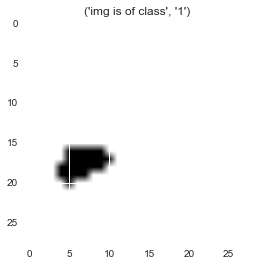

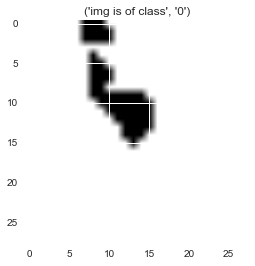

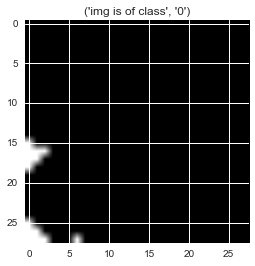

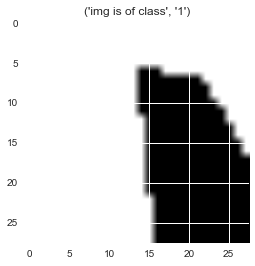

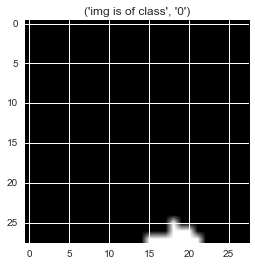

In [159]:
for i in range(5): # let us look at 5 randomly selected images
    rand_int = random.choice(range(X.shape[0]))
    img = X[rand_int]
    plt.imshow(np.reshape(img,[28,28]))
    title = 'img is of class', str(Y[rand_int])
    plt.title(title)
    plt.show()

In [160]:
# checking if there are any NAs or invalid values
NaNLst = np.sum(pd.DataFrame(X).isnull(),0) # missing value count by feature
NaNLst[NaNLst > 0]

Series([], dtype: int64)

In [161]:
X_0 = X[Y==0] # subset to non-convex
X_1 = X[Y==1] # subset to convex

In [162]:
X_0.shape

(25000L, 784L)

In [163]:
X_1.shape

(25000L, 784L)

In [164]:
X_0.sum(1)

array([ 73, 691,  43, ...,  53,  43, 284])

In [165]:
X_1.sum(1)

array([173, 100, 399, ...,  35, 222, 118])

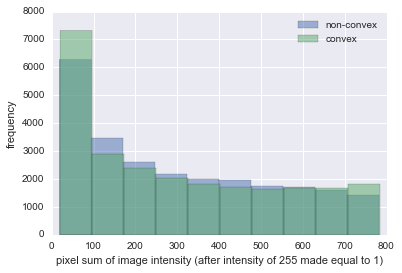

In [166]:
plt.hist(X_0.sum(1), alpha = 0.5, label='non-convex')
plt.hist(X_1.sum(1), alpha = 0.5, label='convex')
plt.xlabel('pixel sum of image intensity (after intensity of 255 made equal to 1)')
plt.ylabel('frequency')
plt.legend()

In [265]:
# visulize the datapoints using PCA
from sklearn.decomposition import PCA
% time pca = PCA().fit(X); pca_X = pca.transform(X)

Wall time: 4.03 s


In [266]:
# variance explaied by first two components
sum(pca.explained_variance_ratio_[:2])

0.50761580498810499

In [267]:
sum(pca.explained_variance_ratio_[:3])

0.62167324945272995

In [268]:
pca_X_red = pca_X.copy()
pca_red = np.column_stack([pca_X_red, np.array(Y)])
np.random.shuffle(pca_red)
pca_red = pca_red[:1000]

(-0.5, 0.5)

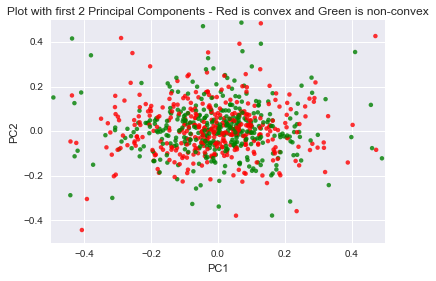

In [241]:
# plotting to see how the results look
colors = np.array(['red' if x == 1 else 'green' for x in list(pca_red[:,-1])])

sns.regplot(pca_red[0], pca_red[1], fit_reg=False, scatter_kws={'c':colors}) 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Plot with first 2 Principal Components - Red is convex and Green is non-convex')
plt.legend()

# zooming in to avoid outliers
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])

(-0.5, 0.5)

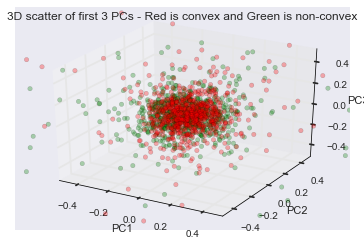

In [269]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# subsets for convex and non-convex images
convex = pca_red[pca_red[:,-1]==1]
nonconvex = pca_red[pca_red[:,-1]==0]

ax.scatter(convex[0], convex[1], convex[2], c='red',alpha=0.3)
ax.scatter(nonconvex[0], nonconvex[1], nonconvex[2], c='green', alpha=0.3)
        
plt.title('3D scatter of first 3 PCs - Red is convex and Green is non-convex')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
ax.set_zlim([-0.5,0.5])

In [264]:
pca_red.shape

(2L, 785L)

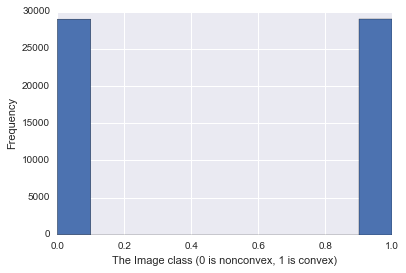

In [145]:
Y_all = np.hstack([Y,Y_test]) # combining test and train data
pd.Series(Y_all).plot(kind='hist') # perfectly balanced --> can use accuracy as performance metric
plt.xlabel('The Image class (0 is nonconvex, 1 is convex)')

### Applying Kernel SVM on the data

In [27]:
from sklearn import svm
from sklearn.cross_validation import KFold

In [30]:
# perform cross validation to determine parameters
#Function to measure the MAE based on different parameters
def calc_params(X, y, clf, param_values, param_name, K):

    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing scores with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):
        #print(param_name, ' = ', param_value)
        
        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation or stratified bootstrap validation
        cv = KFold(len(X), K, shuffle=True, random_state=99)
        
        # iterate over the K folds
        for j, (train, test) in enumerate(cv):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit([X[k] for k in train], y[train])
            
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
       
       # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # plot the training and testing scores in a log scale
    plt.figure()
    if type(param_values[0]) == str: # we are looking at string parameters
        sns.pointplot(param_values,train_scores, palette="Greens_d")
        sns.pointplot(param_values,test_scores, palette="Blues_d")
        plt.title('Green: Train Results, Blue: Test Results')
        plt.xlabel(param_name + " values")
        plt.ylabel("Mean cross validation accuracy value")
        plt.show()
    else:
        plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
        plt.plot(param_values, test_scores, label='Test', alpha=0.4, lw=2, c='g')
        plt.legend(loc=7)
        plt.xlabel(param_name + " values")
        plt.ylabel("Mean cross validation accuracy value")
        plt.show()

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

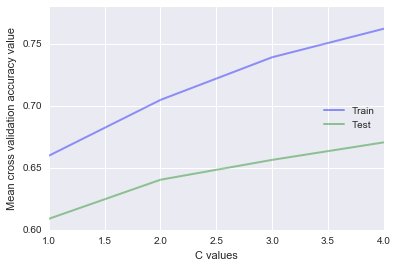

In [29]:
# 3 Fold CV
# test out diff penalities C
svm_cv = svm.SVC(random_state=seed) # initialize the regressor
Cs = list(range(1,5,1))
train_scores, test_scores = calc_params(X, Y, svm_cv, Cs, 'C', 3)

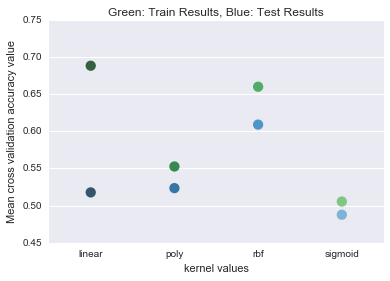

In [45]:
# test out diff penalities C
svm_cv = svm.SVC(random_state=seed) # initialize the regressor
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = calc_params(X, Y, svm_cv, kernels, 'kernel', 3)

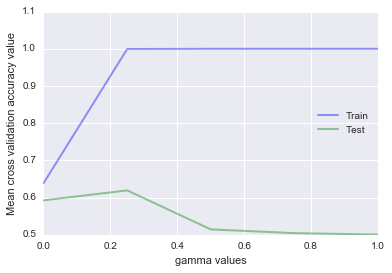

In [31]:
# since RBF clearly provides the better bais-variance trade-off
# We further investigate RBF and tune the sigma value
svm_cv = svm.SVC(random_state=seed, kernel='rbf') # initialize the regressor
gammas = np.linspace(0.001,1, num=5)
train_scores, test_scores = calc_params(X, Y, svm_cv, gammas, 'gamma', 3)

In [192]:
# using the best model:
svm_final_clf = svm.SVC(random_state=seed, kernel='rbf', gamma = 0.25, C=4)
%time fit = svm_final_clf.fit(X,Y)

Wall time: 3h 29min 48s


In [193]:
%time Accuracy_on_test = fit.score(X_test, Y_test) # accuracy on the test data
print 'The accuracy of SVM on the test data is ', str(Accuracy_on_test)

Wall time: 5min 19s
The accuracy of SVM on the test data is  0.693375


In [194]:
## since it is taking so long for the SVm classifier to learn from the data,
## we try with reduced dimensionality, using the features from PCA
## Only using the first two components 
newX = pca.transform(X)[:,:2]
newX_test = pca.transform(X_test)[:,:2]

In [195]:
%time fit_red = svm_final_clf.fit(newX,Y)

Wall time: 2min 22s


In [92]:
%time Accuracy_on_test = fit_red.score(newX_test, Y_test) # accuracy on the test data
print 'The accuracy of SVM on the test data is ', str(Accuracy_on_test)

Wall time: 8.18 s
The accuracy of SVM on the test data is  0.596


In [196]:
# performing classification using LDA to compare the performance 
lda = LinearDiscriminantAnalysis()
%time fit = lda.fit(X,Y)

Wall time: 4.01 s


In [197]:
%time lda.score(X_test, Y_test)

Wall time: 31 ms


0.541875